In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List

E_CHARGE = 1.60217646E-19
E_MASS = 9.10938188E-31
PLANKS = 6.626068E-34
COULOMB = 8.98755179E9


def closest_index_x(n: float) -> int:
    """ closest equivalent to x2pnt"""
    lst = np.arange(-20, 21, 1)
    closest = min(range(len(lst)), key=lambda i: abs(lst[i] - n))

    return closest


class Wave(object):

    def __init__(self, charge_ratio: int, lam: float, eta1: float, eta2: float,
                 d: float, r0: float, el0: float, w0: float, g1_z: float,
                 g2_z: float, g2_x: float, theta: float):
        self.cr = charge_ratio  # strength of image charge
        self.lam = lam  # electron wavelength
        self.eta1 = eta1  # G1 open fraction
        self.eta2 = eta2  # G2 open fraction
        self.d = d  # period of grating

        self.r0 = r0  # initial radius of wavefront
        self.el0 = el0  # initial coherence width
        self.w0 = w0  # initial beam width

        self.g1z = g1_z  # longitudinal position of first grating
        self.g2z = g2_z  # longitudinal position of second grating
        self.g2x = g2_x  # traverse position of second grating

        self.th = theta  # twist between gratings

    def fourier(self, energy: float, width: float, thick: float,
                wedge_angle: float, tilt: float) -> List[float]:
        """
        Include parameters (SAMPLE)
        ---------------------------
        charge ratio = self.cr
        energy = 1.5E-18/self.lam^2
        width = self.eta2*d
        thick = 140E-6
        wedge_angle = 0
        tilt = 0
        """
        global E_CHARGE, E_MASS, PLANKS, COULOMB
        FcT = np.zeros(41, dtype=complex)
        res = 1000
        eta = 1
        vel = np.sqrt(2 * energy * E_CHARGE / E_MASS)
        # vel = round(vel, 7)
        alpha = wedge_angle * np.pi / 180
        beta = tilt * np.pi / 180

        if beta >= 0:
            x_min = -width * np.cos(beta) / 2 + width / res
            if beta <= alpha:
                x_max = width * np.cos(beta) / 2 - width / res
            else:
                x_max = width * np.cos(beta) / 2 - width / res + thick * (np.tan(alpha) - np.tan(beta))
        else:
            x_max = width * np.cos(beta) / 2 - width / res
            if abs(beta) <= alpha:
                x_min = -width * np.cos(beta) / 2 + width / res
            else:
                x_min = -width * np.cos(beta) / 2 + width / res - thick * (np.tan(alpha) - np.tan(beta))

        for n in range(-20, 21):  # nested while loops -> runtime O(n^2) | n = 41 -> not too bad ex = x_min
            ex = x_min
            while ex < x_max:
                fc = 2 * np.pi * n * ex / self.d
                ph = -width * thick * self.cr * E_CHARGE ** 2 * (2 * np.pi * COULOMB / PLANKS) / (
                        vel * (0.25 * (width ** 2 - ex ** 2)))
                FcT[closest_index_x(n)] += np.exp((fc + ph) * 1j)

                ex += width / res

        FcT /= res

        return FcT

    def beam_width(self, z) -> float:
        """ compute GSM beam width as a function of z
        see eqn 6.
        """
        zp = self.mag_factor(z, self.r0)
        w = self.w0 * np.abs(z / zp) * np.sqrt(1 + self.lam ** 2 * zp ** 2 / (self.el0 ** 2 * self.w0 ** 2))
        return w

    def coherence_width(self, z) -> float:
        """ compute GSM coherence width as a function of z
        see eqn 7.
        """
        zp = self.mag_factor(z, self.r0)
        el = self.el0 * np.abs(z / zp) * np.sqrt(1 + self.lam ** 2 * zp ** 2 / (self.el0 ** 2 * self.w0 ** 2))
        return el

    def wfc_radius(self, z) -> float:
        """ compute GSM radius of wavefront curvature as a function of z
        see eqn 8.
        """
        zp = self.mag_factor(z, self.r0)
        v = z / (1 - zp / (z * (1 + self.lam ** 2 * zp ** 2 / (self.el0 ** 2 * self.w0 ** 2))))
        return v

    def mag_factor(self, z, v) -> float:
        """ compute magnification factor due to wavefront curvature"""
        zp = (v * z) / (v + z)
        return zp


if __name__ == "__main__":
    pass

In [ ]:
from wave import *
import matplotlib.pyplot as plt

def gp0(wv, z01, x):
    """
    intensity profile after no grating

    ARGS:
        wv: "Wave" => user defined wave object
        z01: "float" => z position of beam
        x: "np.ndarray" => array of x positions

    RETURNS:
        ix: "np.ndarray" => intensity profile at (x, z01)
    """
    w1 = wv.beam_width(z01)
    ix = np.exp(-np.pi * (x / w1) ** 2)

    return ix

In [ ]:
def gp1(wv, z12, x, FcT):
    """
    intensity profile after one grating

    ARGS:
        wv: "Wave" => user defined wave object
        z12: "float" => z position of beam relative to first d. grating
        x: "np.ndarray" => array of x positions
        FcT: "np.ndarray" => Fourier components of wv

    RETURNS:
        ix: "np.ndarray" => intensity profile at (x, z12)
    """

    el2 = wv.coherence_width(z12)
    w2 = wv.beam_width(z12)
    r2 = wv.wfc_radius(z12)

    cutoff = 1E-3
    # NOTE: lim exponentially effects program runtime, on my mac:
    # lim = 1 can spit out an intensity profile in a second
    # lim = 3 makes the code take about 20 seconds to run
    # lim = 4 takes about as long as the Eagles song: One of These Nights
    # lim = 5 took around 8 minutes and really tested the limits of my computers cooling system
    lim = 2
    ix = 0
    n = -lim
    while n <= lim:
        m = -lim
        while m <= lim:
            dn = n - m
            dm = (m + n) / 2

            if False:       # NOTE: not debugged for when TRUE
                coef = (np.sin(wv.eta1*np.pi*n) / (wv.eta1*np.pi*n)) * (np.sin(wv.eta1 * np.pi * m)/(wv.eta1*np.pi*m)) *\
                       wv.eta1 ** 2
            else:
                coef = (FcT[closest_index_x(n)].real * FcT[closest_index_x(m)].real
                        + FcT[closest_index_x(n)].imag * FcT[closest_index_x(m)].imag)

            coef *= np.exp(-np.pi * (dn * wv.lam * z12 / (wv.d * el2)) ** 2)

            if coef >= cutoff:
                ix += coef * np.exp(-np.pi * ((x - dm * wv.lam * z12 / wv.d) / w2) ** 2) * np.cos(
                    2 * np.pi * (dn / wv.d) * (x - dm * wv.lam * z12 / wv.d) * (1 - z12 / r2))

            m += 1
        n += 1
    return ix



In [ ]:
def gp2(wv, z12, z23, x, FcT):
    """
     intensity profile after two gratings

    ARGS:
        wv: "Wave" => user defined wave object
        z12: "float" => z position of second d. grating relative to
        first d. grating
        z23: "float" => z position of beam relative to second d. grating
        x: "np.ndarray" => array of x positions
        FcT: "np.ndarray" => Fourier components of wv

    RETURNS:
        ix: "np.ndarray" => intensity profile at (x, z23)
    """
    theta = np.pi * wv.th / 180

    d1 = wv.d
    d2 = d1

    if True:
        # simulate beam components after passing first grating
        z13 = z12 + z23   # z position of beam relative to first d. grating
        el3x = wv.coherence_width(z13)
        w3x = wv.beam_width(z13)
        v3x = wv.wfc_radius(z13)

        el3y = el3x
        w3y = w3x
        v3y = v3x

        ix = 0
        phix = 0
        phi = 0
        cutoff = 1E-3
        # NOTE: lim exponentially effects program runtime, on my mac:
        # lim = 1 can spit out an intensity profile in a second
        # lim = 3 makes the code take about 20 seconds to run
        # lim = 4 takes about as long as the Eagles song: One of These Nights
        # lim = 5 took around 8 minutes and really tested the limits of my computers cooling system
        lim = 2
        m1 = -lim
        while m1 <= lim:
            m2 = -lim
            while m2 <= lim:
                n1 = -lim
                while n1 <= lim:
                    n2 = -lim
                    while n2 <= lim:

                        dn = n1 - n2
                        n = (n1 + n2) / 2
                        dm = m1 - m2
                        m = (m1 + m2) / 2

                        if False:       # NOTE: not debugged for when TRUE
                            coef = complex(np.sin(wv.eta1 * np.pi * m1) / (wv.eta1 * np.pi * m1), 0)
                            coef *= complex(np.sin(wv.eta1 * np.pi * m2) / (wv.eta1 * np.pi * m2), 0)
                        else:
                            coef = FcT[closest_index_x(m1)]
                            coef *= complex(FcT[closest_index_x(m2)].real, -FcT[closest_index_x(m2)].imag)
                        coef *= FcT[closest_index_x(n1)]
                        coef *= complex(FcT[closest_index_x(n2)].real, -FcT[closest_index_x(n2)].imag)
                        coef *= np.exp(-np.pi * (n * np.sin(theta) * wv.lam * z23 / (d2 * w3y))**2)
                        coef *= np.exp(-np.pi * (dn * np.sin(theta) * wv.lam * z23 / (d2 * el3y)) ** 2)
                        coef *= np.exp(-np.pi * (wv.lam * z23 * (dn * np.cos(theta) + dm * z13 / z23) / (d1 * el3x))**2)

                        if coef.real >= cutoff or coef.imag >= cutoff:
                            phi = dn * n * (1 - z23 / v3x) * np.cos(theta)**2 + dn * n * (1 - z23 / v3y) * np.sin(theta)**2 + dn * m * ( 1 - z13 / v3x) * np.cos(theta)
                            phi += dm * n * (1 - z13 / v3x) * np.cos(theta) + dm * m * (z13 / z23) * ( 1 - z13 / v3x)
                            phi *= 2 * np.pi * wv.lam * z23 / (d1**2)
                            phi -= 2 * np.pi * dn * wv.g2x / d2
                            phix = phi - (2 * np.pi * x / d2) * (dn * np.cos(theta) * (1 - z23 / v3x) + dm * (1 - z13 / v3x))
                            ix += (coef.real * np.cos(phix) - coef.imag * np.sin(phix)) * np.exp(-np.pi * ((x - (wv.lam * z23 / d1) * (n * np.cos(theta) + m * z13 / z23)) / w3x)**2)

                        n2 += 1
                    n1 += 1
                m2 += 1
            m1 += 1
    else:       # NOTE: not debugged for when TRUE

        lim = 2
        ix = 0
        gwin = 0

        for x1 in np.arange(gwin * wv.d - wv.eta1 * wv.d / 2, gwin * wv.d + wv.eta1 * wv.d / 2, wv.eta1 * wv.d / 25):
            rea = 0
            ima = 0

            for j in range(-lim, lim + 1):
                phi = np.pi * (wv.lam / wv.d**2) * (z12 * z23 / (z12 + z23)) * j**2
                rea += ReT[closest_index_x(j)] * np.cos(-phi + 2 * np.pi * j * (x1 * z23 + x1 * z12) / (wv.d * (z12 + z23)))
                rea -= ImT[closest_index_x(j)] * np.sin(-phi + 2 * np.pi * j * (x1 * z23 + x1 * z12) / (wv.d * (z12 + z23)))
                ima += ReT[closest_index_x(j)] * np.sin(-phi + 2 * np.pi * j * (x1 * z23 + x1 * z12) / (wv.d * (z12 + z23)))
                ima += ImT[closest_index_x(j)] * np.cos(-phi + 2 * np.pi * j * (x1 * z23 + x1 * z12) / (wv.d * (z12 + z23)))
            ix += rea**2 + ima**2

    return ix

In [ ]:
def main():
    """ contains main loop that checks position of beam at each
    point in z-x grid, determines if the beam has passed through zero, one,
    or two gratings, and stores the beam width at each point"""

    # compute beam components
    lam = 0.56 * 1E-9
    wave1 = Wave(0, lam, 0.5, 0.5,
                 1E-7, -999999999999999999999, 1E-3, 1E-3, 0.005, 0.055, 0, 0)

    # compute Fourier components of beam
    energy = 4000
    FcT = wave1.fourier(energy, wave1.eta2 * wave1.d, 140e-9, 0, 0)

    # compute beam components after first d. grating
    r1 = wave1.wfc_radius(wave1.g1z)
    el1 = wave1.coherence_width(wave1.g1z)
    w1 = wave1.beam_width(wave1.g1z)

    wave2 = Wave(0, lam, 0.8, 0.8,
                 1E-7, r1, el1, w1, 0.005, 0.055, 0, 0)

    # grid parameters
    izx = []

    z_start = 1E-6
    z_end = 0.1025
    z_pnts = 500

    x_start = -2E-3
    x_end = 2E-3
    x_pnts = 500

    y_start = -0.22E-2
    y_end = 0.22E-2
    y_pnts = 500

    # grid setup
    x_scale = np.linspace(x_start, x_end, x_pnts)
    y_scale = np.linspace(y_start, y_end, y_pnts)
    z_scale = np.linspace(z_start, z_end, z_pnts)

    x_axis, z_axis = np.meshgrid(x_scale, z_scale)

    z_res = (z_end - z_start) / z_pnts

    i = 0
    while i < z_pnts:       # increment through each point in z-axis
        z = z_start + i * z_res

        if False:       # NOTE: not debugged for when TRUE
            wave1.g2z = z
            wave2.g2z = z
            z = 0.75

        if False:       # NOTE: not debugged for when TRUE
            wave1.g2x = -z * wave1.d
            wave2.g2x = -z * wave2.d
            z = 1

        if z > wave1.g2z:  # intensity at (x, z) after two gratings
            ix = gp2(wave2, wave2.g2z - wave2.g1z, z - wave2.g2z, x_scale, FcT)

        elif z > wave1.g1z:  # intensity at (x, z) after one grating
            ix = gp1(wave2, z - wave1.g1z, x_scale, FcT)

        else:  # intensity at (x, z) with no gratings
            ix = gp0(wave1, z, x_scale)

        # normalize intensity column to one
        ix /= ix.max()
        izx.append(ix)

        i += 1

    # display intensity profile
    plt.scatter(x_axis, z_axis, c=izx)
    plt.show()

    np.savetxt("izx_py.csv", izx, delimiter=",")

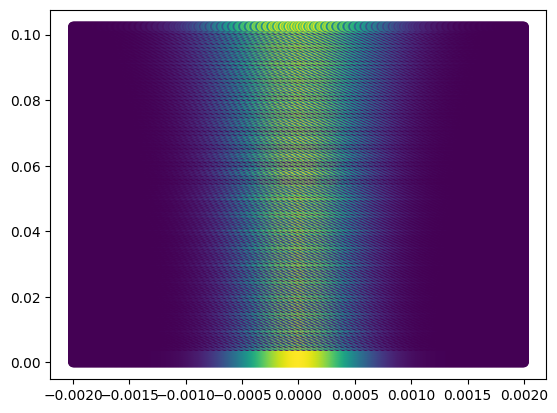

In [ ]:
if __name__ == "__main__":
  main()

In [ ]:
import pandas as pd

# Read the data from the files into Pandas DataFrames
df1 = pd.read_csv('corrected.python.izx.transposed.csv')
df2 = pd.read_csv('mathematica.izx 2.csv')

# Convert the DataFrames to NumPy arrays for element-wise subtraction
array1 = df1.values
array2 = df2.values

# Perform element-wise subtraction
result_array = ((array1 - array2)/array2)

# If you want to convert the result back to a DataFrame or save it to a new file
result_df = pd.DataFrame(result_array)
result_df.to_csv('result.csv', index=False)

<ipython-input-44-031d2a5a8be5>:12: RuntimeWarning: divide by zero encountered in true_divide
  result_array = ((array1 - array2)/array2)


In [ ]:
np.savetxt("relativediff.csv", result_df)

ValueError: ignored

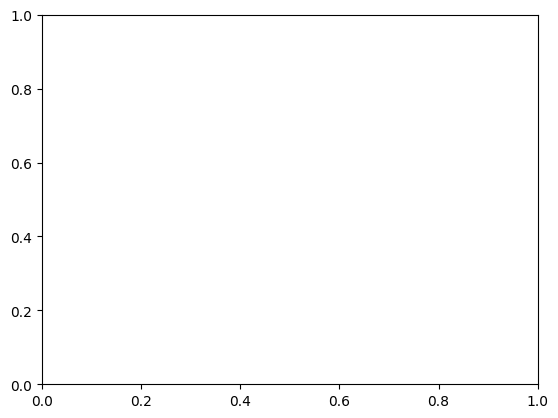

In [ ]:
result_df = pd.read_csv('result.csv')
values = result_df.values.flatten()

plt.scatter(range(len(values)), values)
plt.xlabel('X Axis')
plt.ylabel('Z Axis')
plt.title('Scatter Plot of Values')
plt.show()

ValueError: ignored

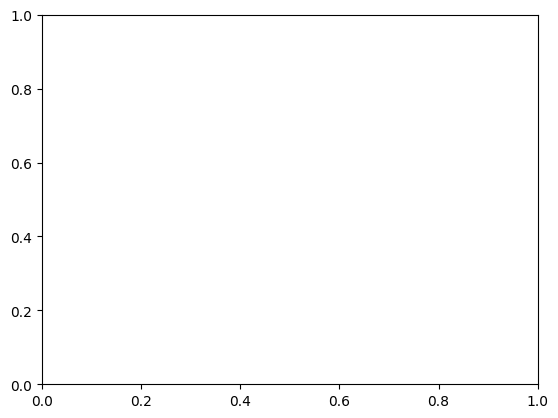

In [ ]:
plt.scatter(x_axis, z_axis, c=result_array)